In [89]:
from os import listdir
from sklearn.model_selection import train_test_split
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
from keras.applications import InceptionResNetV2
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
!echo "Number of Normal images"
!ls -l data/DATA_I_MADE/Images/Normal | egrep -c '^-'

Number of Normal images
541


In [3]:
!echo "Number of Trolled images"
!ls -l data/DATA_I_MADE/Images/Trolled | egrep -c '^-'

Number of Trolled images
557


In [4]:
Normal_Images = ['data/DATA_I_MADE/Images/Normal/'+i for i in listdir('data/DATA_I_MADE/Images/Normal')]
Trolled_Images = ['data/DATA_I_MADE/Images/Trolled/'+i for i in listdir('data/DATA_I_MADE/Images/Trolled')]
Y_normal = [0]*len(Normal_Images)
Y_trolled = [1]*len(Trolled_Images)
len(Normal_Images),len(Y_normal),len(Trolled_Images),len(Y_trolled)

(541, 541, 557, 557)

In [5]:
Images = Normal_Images+Trolled_Images
labels = Y_normal+Y_trolled
len(Images),len(labels)

(1098, 1098)

In [16]:
trainX, testX, trainY, testY = train_test_split(Images, labels, test_size=0.1, random_state=42, stratify=labels)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.11, random_state=42, stratify=trainY)

In [17]:
len(trainX),len(trainY),len(testX),len(testY),len(valX),len(valY)

(879, 879, 110, 110, 109, 109)

In [19]:
def dump_to_pkl(file_location,item):
    with open(file_location, 'wb') as fp:
        pickle.dump(item, fp)

In [21]:
dump_to_pkl('data/DATA_I_MADE/train_test_val_split/trainX.pickle',trainX)
dump_to_pkl('data/DATA_I_MADE/train_test_val_split/testX.pickle',testX)
dump_to_pkl('data/DATA_I_MADE/train_test_val_split/valX.pickle',valX)
dump_to_pkl('data/DATA_I_MADE/train_test_val_split/trainY.pickle',trainY)
dump_to_pkl('data/DATA_I_MADE/train_test_val_split/testY.pickle',testY)
dump_to_pkl('data/DATA_I_MADE/train_test_val_split/valY.pickle',valY)

In [22]:
def read_from_pkl(file_location):
    with open (file_location, 'rb') as fp:
        itemlist = pickle.load(fp)
    return itemlist

In [53]:
trainX = read_from_pkl('data/DATA_I_MADE/train_test_val_split/trainX.pickle')
testX = read_from_pkl('data/DATA_I_MADE/train_test_val_split/testX.pickle')
valX = read_from_pkl('data/DATA_I_MADE/train_test_val_split/valX.pickle')
trainY = read_from_pkl('data/DATA_I_MADE/train_test_val_split/trainY.pickle')
testY = read_from_pkl('data/DATA_I_MADE/train_test_val_split/testY.pickle')
valY = read_from_pkl('data/DATA_I_MADE/train_test_val_split/valY.pickle')

In [54]:
length = 306
width = 306
channels = 3

In [55]:
def read_and_process_image(list_of_images):
    X = [] 
    for image in tqdm(list_of_images):
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (length,width), interpolation=cv2.INTER_CUBIC))  
    return X

In [56]:
trainX = read_and_process_image(trainX)
testX = read_and_process_image(testX)
valX = read_and_process_image(valX)

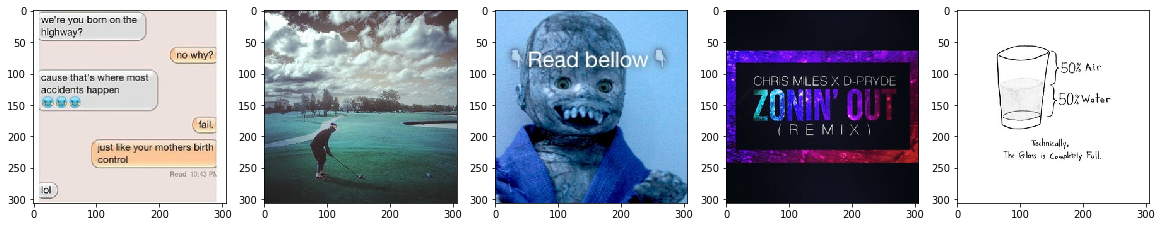

In [57]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(trainX[i])

In [58]:
trainX = np.array(trainX)
testX = np.array(testX)
valX = np.array(valX)
trainY = np.array(trainY)
testY = np.array(testY)
valY = np.array(valY)

In [62]:
ntrain = len(trainX)
ntest = len(testX)
nval = len(valX)

In [63]:
batch_size = 32

In [65]:
conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(306,306,3))

Instructions for updating:
Colocations handled automatically by placer.
219062272/219055592 [==============================] - 45s 0us/step


In [66]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 306, 306, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 152, 152, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 152, 152, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 152, 152, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Total params: 54,336,736
Trainable params: 54,276,192
Non-trainable params: 60,544
__________________________________________________________________________________________________


In [68]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [69]:
conv_base.trainable = False

In [72]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['acc'])

In [74]:
train_datagen = ImageDataGenerator(rescale=1./255,   
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_val_datagen = ImageDataGenerator(rescale=1./255)

In [75]:
train_generator = train_datagen.flow(trainX, trainY,batch_size=batch_size)
val_generator = test_val_datagen.flow(valX, valY, batch_size=batch_size)

In [76]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
27/27 [==============================] - 78s 3s/step - loss: 0.7783 - acc: 0.5243 - val_loss: 0.8303 - val_acc: 0.4688
Epoch 2/20
27/27 [==============================] - 62s 2s/step - loss: 0.7067 - acc: 0.5797 - val_loss: 0.6967 - val_acc: 0.5974
Epoch 3/20
27/27 [==============================] - 62s 2s/step - loss: 0.6858 - acc: 0.5709 - val_loss: 0.8169 - val_acc: 0.5455
Epoch 4/20
27/27 [==============================] - 62s 2s/step - loss: 0.6582 - acc: 0.6460 - val_loss: 0.7491 - val_acc: 0.5714
Epoch 5/20
27/27 [==============================] - 63s 2s/step - loss: 0.6383 - acc: 0.6242 - val_loss: 0.7525 - val_acc: 0.5729
Epoch 6/20
27/27 [==============================] - 61s 2s/step - loss: 0.6261 - acc: 0.6704 - val_loss: 0.8980 - val_acc: 0.5195
Epoch 7/20
27/27 [==============================] - 58s 2s/step - loss: 0.6061 - acc: 0.6682 - val_loss: 0.7425 - val_acc: 0.5974
Epoch 8/20
27/27 [========================

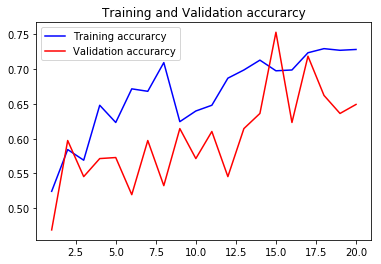

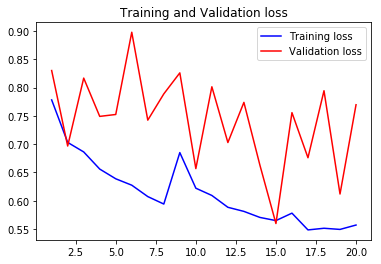

In [78]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [79]:
def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

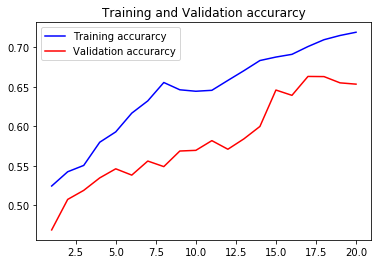

In [80]:
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurarcy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()

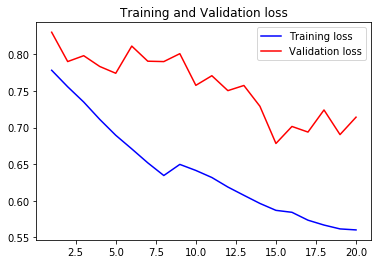

In [81]:
plt.plot(epochs, smooth_plot(loss), 'b', label='Training loss')
plt.plot(epochs, smooth_plot(val_loss), 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [86]:
test_pred_labels=[]
i=0
for batch in tqdm(test_val_datagen.flow(testX, batch_size=1)):
    pred = model.predict(batch)
    if pred > 0.5:
        test_pred_labels.append(1)
    else:
        test_pred_labels.append(0)
    i+=1
    if i==ntest:
        break

In [90]:
accuracy_score(testY, test_pred_labels)

0.5363636363636364